# Naive Seasonal Baseline

#### Setup

In [1]:
import os
import sys
from pathlib import Path
from hydra import initialize, compose
from omegaconf import OmegaConf
from matplotlib import pyplot as plt
from utilsforecast.evaluation import evaluate

from darts import TimeSeries
from pandas import DataFrame

Load an arbitrary config to load the datamodule

In [2]:
initialize(
    version_base=None,
    config_path="../configs",
)
cfg = compose(
    config_name="lightgbm-uni.yaml",
)

###### Resolve Hydra Config

In [3]:
os.chdir('..')

from src import pipelines

datamodule, _ = pipelines.resolve_config(cfg)

get dataset from datamodule

In [4]:
Y_df = datamodule.pipeline()

/home/emilyschiller/dev_dsaa/no-data-left-behind/src/data/staff_data.py:270: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat([all_data, influenza_data[["Meldewoche", "Erkrankung", "Inzidenz"]]])
/home/emilyschiller/dev_dsaa/no-data-left-behind/src/data/staff_data.py:311: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.14' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_appended.loc[intervall_in_occurence, f"{row['Erkrankung']}_incidence"] = row["Inzidenz"]


In [5]:
print(sys.path)

['/home/emilyschiller/dev_dsaa/no-data-left-behind/.venv/lib/python3.10/site-packages/ray/thirdparty_files', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/emilyschiller/dev_dsaa/no-data-left-behind/.venv/lib/python3.10/site-packages', '/home/emilyschiller/dev_dsaa/no-data-left-behind/.venv/lib/python3.10/site-packages/setuptools/_vendor']


In [6]:
Y_df.head(3)

,Unnamed: 0,ds,y,ward_A_planned_absences,ward_A_unplanned_absences,ward_B_nursing_staff_capacity,ward_B_planned_absences,ward_B_unplanned_absences,ward_C_nursing_staff_capacity,ward_C_planned_absences,...,cos_day_of_week,sin_day_of_year,cos_day_of_year,sin_day_of_month,cos_day_of_month,sin_month_of_year,cos_month_of_year,sin_hour_of_day,cos_hour_of_day,unique_id
0,0,2022-01-01 12:00:00,9,50,5,12,38,5,7,38,...,-0.222521,0.017213,0.999852,0.201299,0.97953,0.5,0.866025,1.224647e-16,-1.000000,ward_A_nursing_staff_capacity
1,1,2022-01-01 13:00:00,14,50,8,20,38,6,12,38,...,-0.222521,0.017213,0.999852,0.201299,0.97953,0.5,0.866025,-2.588190e-01,-0.965926,ward_A_nursing_staff_capacity
2,2,2022-01-01 14:00:00,14,50,8,20,38,6,12,38,...,-0.222521,0.017213,0.999852,0.201299,0.97953,0.5,0.866025,-5.000000e-01,-0.866025,ward_A_nursing_staff_capacity


configure evaluation

get callables from metric names

In [7]:
from src.evaluation import get_metric

eval_cfg = cfg.evaluation
metrics = {k: get_metric(k) for k in eval_cfg.metrics}
print(metrics)

{'mae': <function mae at 0x7fb48dbef7f0>, 'rmse': <function rmse at 0x7fb48dbef910>, 'smape': <function smape at 0x7fb48dbefac0>}


## Model Training
Train a NaiveSeasonal model with K=24, corresponding to daily seasonality

In [8]:
from darts.models import NaiveSeasonal

In [9]:
modelDaily = NaiveSeasonal(K=24)

Split train and test data

In [10]:
from src.data import utils

kwargs = {}
test_start_date = "2023-04-01"  # eval
df_train, df_test = utils.split_train_test(Y_df, test_start_date)
test_start_date = df_test.iloc[0]["ds"]
kwargs["test_start"] = test_start_date
print(f"train shape: {df_train.shape}")
print(f"test split start: {test_start_date}")
print(
    f"test split shape: {df_test.shape}, which is {len(df_test) / len(Y_df):.1%} of the total dataset."
)

debug: received test split start fixed date: 2023-04-01 00:00:00
train shape: (10908, 51)
test split start: 2023-04-01 00:00:00
test split shape: (2161, 51), which is 16.5% of the total dataset.


In [11]:
train_series = TimeSeries.from_dataframe(
    df_train, time_col="ds", value_cols="y", freq=cfg.dataset.freq
)
train_series

<TimeSeries (DataArray) (ds: 10908, component: 1, sample: 1)> Size: 87kB
array([[[ 9.]],

       [[14.]],

       [[14.]],

       ...,

       [[13.]],

       [[ 5.]],

       [[ 5.]]])
Coordinates:
  * ds         (ds) datetime64[ns] 87kB 2022-01-01T12:00:00 ... 2023-03-31T23...
  * component  (component) object 8B 'y'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

fit the model

In [12]:
modelDaily.fit(
    series=train_series,
)

NaiveSeasonal(K=24)

In [13]:
df = TimeSeries.from_dataframe(Y_df, time_col="ds", value_cols="y", freq=cfg.dataset.freq)

----

Evaluate the model

In [14]:
import pandas as pd

l_timeseries = modelDaily.historical_forecasts(
    series=df,
    start=test_start_date,
    forecast_horizon=cfg.evaluation.horizon,
    stride=cfg.evaluation.horizon,
    last_points_only=False,
    verbose=True,
    show_warnings=True,
    retrain=True,
)
if isinstance(l_timeseries, list):
    ts_df = pd.concat([t.pd_dataframe() for t in l_timeseries])
else:
    ts_df = l_timeseries.pd_dataframe()
print("historical_forecasts output:")
ts_df

  0%|          | 0/3 [00:00<?, ?it/s]

historical_forecasts output:


component,y
ds,
2023-04-01 00:00:00,5.0
2023-04-01 01:00:00,5.0
2023-04-01 02:00:00,5.0
2023-04-01 03:00:00,5.0
2023-04-01 04:00:00,5.0
...,...
2023-06-29 19:00:00,9.0
2023-06-29 20:00:00,13.0
2023-06-29 21:00:00,13.0


In [15]:
ts_df = ts_df.reset_index()
ts_df = ts_df.rename(columns={"y": "NaiveSeasonalDaily"})
ts_df = ts_df.merge(df_test, how="left", on="ds")
ts_df.head()

,ds,NaiveSeasonalDaily,Unnamed: 0,y,ward_A_planned_absences,ward_A_unplanned_absences,ward_B_nursing_staff_capacity,ward_B_planned_absences,ward_B_unplanned_absences,ward_C_nursing_staff_capacity,...,cos_day_of_week,sin_day_of_year,cos_day_of_year,sin_day_of_month,cos_day_of_month,sin_month_of_year,cos_month_of_year,sin_hour_of_day,cos_hour_of_day,unique_id
0,2023-04-01 00:00:00,5.0,10908,5,31,13,4,51,11,3,...,-0.222521,0.999991,0.004304,0.201299,0.97953,0.866025,-0.5,0.000000,1.000000,ward_A_nursing_staff_capacity
1,2023-04-01 01:00:00,5.0,10909,5,31,13,4,51,11,3,...,-0.222521,0.999991,0.004304,0.201299,0.97953,0.866025,-0.5,0.258819,0.965926,ward_A_nursing_staff_capacity
2,2023-04-01 02:00:00,5.0,10910,5,31,13,4,51,11,3,...,-0.222521,0.999991,0.004304,0.201299,0.97953,0.866025,-0.5,0.500000,0.866025,ward_A_nursing_staff_capacity
3,2023-04-01 03:00:00,5.0,10911,5,31,13,4,51,11,3,...,-0.222521,0.999991,0.004304,0.201299,0.97953,0.866025,-0.5,0.707107,0.707107,ward_A_nursing_staff_capacity
4,2023-04-01 04:00:00,5.0,10912,5,31,13,4,51,11,3,...,-0.222521,0.999991,0.004304,0.201299,0.97953,0.866025,-0.5,0.866025,0.500000,ward_A_nursing_staff_capacity


<Axes: >

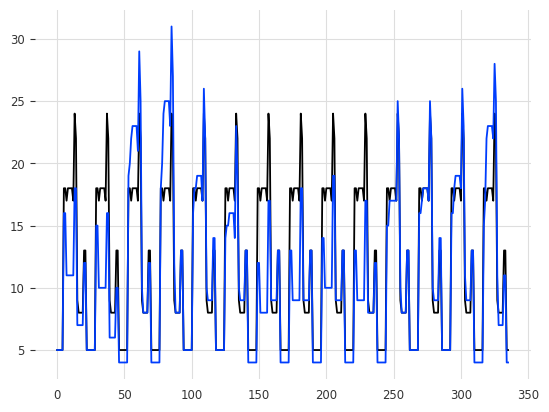

In [16]:
ts_df["NaiveSeasonalDaily"][0:336].plot()
ts_df["y"][0:336].plot()

In [17]:
evaluate(ts_df, metrics=list(metrics.values()), models=["NaiveSeasonalDaily"])

,unique_id,metric,NaiveSeasonalDaily
0,ward_A_nursing_staff_capacity,mae,2.553241
1,ward_A_nursing_staff_capacity,rmse,4.041738
2,ward_A_nursing_staff_capacity,smape,0.103219


Let's try weekly seasonality (24*7=168)

In [18]:
modelWeekly = NaiveSeasonal(K=168)

Fit the model

In [19]:
modelWeekly.fit(
    series=train_series,
)

NaiveSeasonal(K=168)

In [20]:
l_timeseries = modelWeekly.historical_forecasts(
    series=df,
    start=test_start_date,
    forecast_horizon=cfg.evaluation.horizon,
    stride=cfg.evaluation.horizon,
    last_points_only=False,
    verbose=True,
    show_warnings=True,
    retrain=True,
)
if isinstance(l_timeseries, list):
    ts_df = pd.concat([t.pd_dataframe() for t in l_timeseries])
else:
    ts_df = l_timeseries.pd_dataframe()
print("historical_forecasts output:")
ts_df

  0%|          | 0/3 [00:00<?, ?it/s]

historical_forecasts output:


component,y
ds,
2023-04-01 00:00:00,5.0
2023-04-01 01:00:00,5.0
2023-04-01 02:00:00,5.0
2023-04-01 03:00:00,5.0
2023-04-01 04:00:00,5.0
...,...
2023-06-29 19:00:00,8.0
2023-06-29 20:00:00,13.0
2023-06-29 21:00:00,13.0


In [21]:
ts_df = ts_df.reset_index()
ts_df = ts_df.rename(columns={"y": "NaiveSeasonalWeekly"})
ts_df = ts_df.merge(df_test, how="left", on="ds")
ts_df.head()

,ds,NaiveSeasonalWeekly,Unnamed: 0,y,ward_A_planned_absences,ward_A_unplanned_absences,ward_B_nursing_staff_capacity,ward_B_planned_absences,ward_B_unplanned_absences,ward_C_nursing_staff_capacity,...,cos_day_of_week,sin_day_of_year,cos_day_of_year,sin_day_of_month,cos_day_of_month,sin_month_of_year,cos_month_of_year,sin_hour_of_day,cos_hour_of_day,unique_id
0,2023-04-01 00:00:00,5.0,10908,5,31,13,4,51,11,3,...,-0.222521,0.999991,0.004304,0.201299,0.97953,0.866025,-0.5,0.000000,1.000000,ward_A_nursing_staff_capacity
1,2023-04-01 01:00:00,5.0,10909,5,31,13,4,51,11,3,...,-0.222521,0.999991,0.004304,0.201299,0.97953,0.866025,-0.5,0.258819,0.965926,ward_A_nursing_staff_capacity
2,2023-04-01 02:00:00,5.0,10910,5,31,13,4,51,11,3,...,-0.222521,0.999991,0.004304,0.201299,0.97953,0.866025,-0.5,0.500000,0.866025,ward_A_nursing_staff_capacity
3,2023-04-01 03:00:00,5.0,10911,5,31,13,4,51,11,3,...,-0.222521,0.999991,0.004304,0.201299,0.97953,0.866025,-0.5,0.707107,0.707107,ward_A_nursing_staff_capacity
4,2023-04-01 04:00:00,5.0,10912,5,31,13,4,51,11,3,...,-0.222521,0.999991,0.004304,0.201299,0.97953,0.866025,-0.5,0.866025,0.500000,ward_A_nursing_staff_capacity


<Axes: >

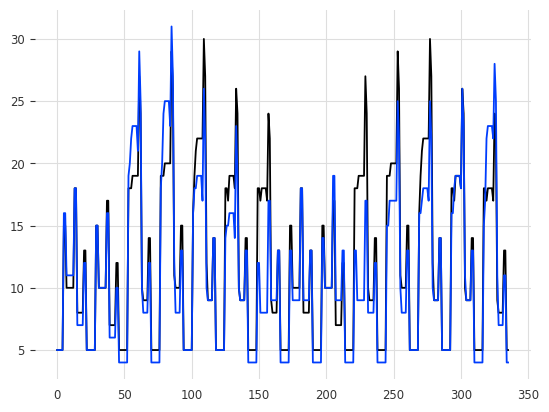

In [22]:
ts_df["NaiveSeasonalWeekly"][0:336].plot()
ts_df["y"][0:336].plot()

In [23]:
evaluate(ts_df, metrics=list(metrics.values()), models=["NaiveSeasonalWeekly"])

,unique_id,metric,NaiveSeasonalWeekly
0,ward_A_nursing_staff_capacity,mae,1.563889
1,ward_A_nursing_staff_capacity,rmse,2.519553
2,ward_A_nursing_staff_capacity,smape,0.066155
